# generate figures for a movie

Distributes figure generation across a dask cluster

png figures can then be assembled into a movie with [Image2Movie](http://jeffreyearly.com/programming/image2movie/)

In [1]:
from glob import glob

import numpy as np
import dask.dataframe as dd
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt

import crocosi.postp as pp
import crocosi.plot as cplt
from crocosi.jet import set_relevant_time

---

In [ ]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
# may break with a local (1 node) cluster
# with typical matplotlib thread issue:
# https://github.com/pydata/xarray/issues/1889
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(jobs=2)
#
client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.1.39:58410 Dashboard: http://10.148.1.39:8787/status,Cluster Workers: 56 Cores: 56 Memory: 240.24 GB


---

In [8]:
root_path = '/home/c11-data/Test_aponte/jetn/'
run = 'jet_cfg1_wp6_4km_500a1000j/'

r = pp.Run(root_path+run, 
           outputs=['surf'],
           tdir_max=1,
           chunks={'surf': {'time_counter': 1}},
           verbose=1)
#set_relevant_time(r) # this triggers slow computations later on, don't know why

Analysing directory /home/c11-data/Test_aponte/jetn/jet_cfg1_wp6_4km_500a1000j/
Found 1 segments
Parameters detected in croco.in :
  time step = 300.0 s
Parameters detected in output.mpi :
Opening datasets: grid / surf
Grid size: (L ,M, N) = (258, 722, 50)


In [9]:
#df = dd.read_csv(glob(root_path+run+'t?/float.????'), 
df = dd.read_csv(glob(root_path+run+'t1/float.????'), 
                 names=['id','time','xgrid','ygrid','zgrid','depth','temp','X1','X2','X3','X4','X5'],
                 delim_whitespace=True).persist()
df.head()

,id,time,xgrid,ygrid,zgrid,depth,temp,X1,X2,X3,X4,X5
0,1,500.00694,13.000887,150.49954,50.0,0.460841,24.579442,0.011823,-0.006198,5.940431e-10,-8.043187e-09,5.395933
1,2,500.00694,13.000894,152.00456,50.0,0.460210,24.579438,0.011932,-0.006193,5.359307e-10,-8.792587e-09,5.389742
2,3,500.00694,13.000902,153.50956,50.0,0.459573,24.579434,0.012037,-0.006189,-3.680414e-10,-9.371084e-09,5.383488
3,4,500.00694,13.000910,155.01459,50.0,0.458930,24.579431,0.012140,-0.006175,-1.238452e-09,-9.359087e-09,5.377181
4,5,500.00694,13.000917,156.51962,50.0,0.458280,24.579427,0.012243,-0.006146,-2.069032e-09,-9.349599e-09,5.370808


## single variable movie

In [5]:
def atom(ax, da, ax_kwargs={}, test=None, **kwargs):
    #
    xc = next((x for x in da.dims if x[0]=='x'), False)
    yc = next((x for x in da.dims if x[0]=='y'), False)
    da = da.assign_coords(x=da[xc]/1e3, y=da[yc]/1e3)
    #
    d = int(da.time_instant)
    h = (da.time_instant-d)*24
    title = da.name+' day = %d / h = %.2f hour '%(d, h)
    #
    da.plot(x='x',y='y', ax=ax, **kwargs)
    ax.set_aspect('equal', 'box')
    ax.set(**ax_kwargs)
    ax.set_title(title)

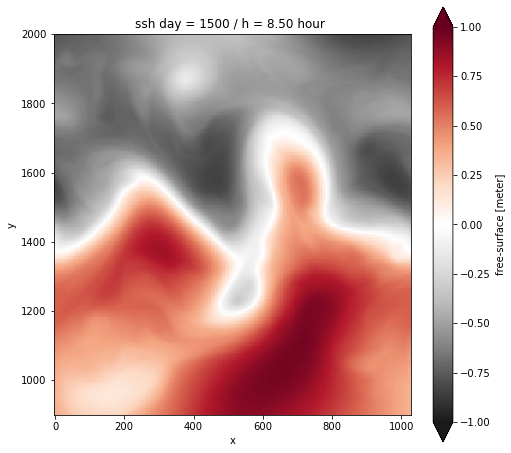

In [6]:
da = r['surf']['ssh']
atom_kw = {'vmin': -1., 'vmax': 1., 'cmap': 'RdGy_r', 
          'extend':'both'}
ax_kw = {'ylim': (900, 2000)}
cplt.movie_figure(atom, da, i=50, test=True, figsize=(8,8), 
                  ax_kwargs=ax_kw, **atom_kw)

In [8]:
cplt.movie_wrapper(atom, client, da.isel(time=slice(0,None, 6*24)),
                   figsize=(8,8),
                   ax_kwargs=ax_kw, **atom_kw)

1 batches to be done
 batch 0-99


## two variable movie

In [10]:
def atom(ax, da0, da1, ax_kwargs={}, test=None, kw0={}, kw1={}, **kwargs):
    #
    da = da0
    xc = next((x for x in da.dims if x[0]=='x'), False)
    yc = next((x for x in da.dims if x[0]=='y'), False)
    da = da.assign_coords(x=da[xc]/1e3, y=da[yc]/1e3)
    da1 = da1.assign_coords(x=da[xc]/1e3, y=da[yc]/1e3)
    #
    d = int(da.time_instant)
    h = (da.time_instant-d)*24
    title = da.name+' day = %d / h = %.2f hour '%(d, h)
    #
    da1.plot(x='x',y='y', ax=ax, **kw1)
    da.plot.contour(x='x',y='y', ax=ax, **kw0)
    ax.set_aspect('equal', 'box')
    ax.set(**ax_kwargs)
    ax.set_title(title)

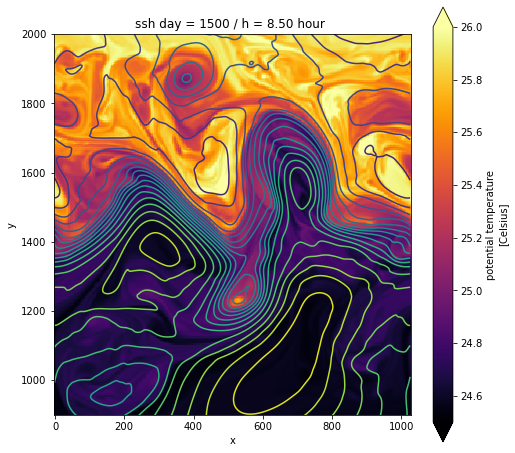

In [13]:
da0 = r['surf']['ssh']
da1 = r['surf']['T']
kw0 = {'vmin': -1., 'vmax': 1.,
       'levels': 20}
kw1 = {'vmin': 24.5, 'vmax': 26.,
       'cmap': 'inferno', 
       'extend':'both'}
ax_kw = {'ylim': (900, 2000)}
cplt.movie_figure(atom, da0, da1, i=50, test=True, figsize=(8,8), 
                  ax_kwargs=ax_kw, **{'kw0': kw0, 'kw1':kw1})

In [14]:
cplt.movie_wrapper(atom, client, 
                   da0.isel(time=slice(0,None, 6*24)),
                   da1.isel(time=slice(0,None, 6*24)),
                   figsize=(8,8),
                   ax_kwargs=ax_kw, **{'kw0': kw0, 'kw1':kw1})

1 batches to be done
 batch 0-99


## with drifters

we need to adjust here movie_wrapper to account for dataframe data

In [25]:
# time window for floats spaghettis
dt=1.

def atom(ax, da, df, ax_kwargs={}, test=False, kw0={}, kw1={}, **kwargs):
    #
    xc = next((x for x in da.dims if x[0]=='x'), False)
    yc = next((x for x in da.dims if x[0]=='y'), False)
    da = da.assign_coords(x=da[xc]/1e3, y=da[yc]/1e3)
    #
    time = da['time_instant'].values
    d = int(time)
    h = (time-d)*24
    title = da.name+' day = %d / h = %.2f hour '%(d, h)
    #
    da.plot(x='x',y='y', ax=ax, **kw0)
    #
    ldf = df[ (df.time>=time-dt) & (df.time<=time) ]
    if test:
        ldf = ldf.compute()
    ax.scatter(ldf.xgrid*4e3/1e3, ldf.ygrid*4e3/1e3, **kw1) # dx, dy hardcoded: bad form
    #
    ax.set_aspect('equal', 'box')
    ax.set(**ax_kwargs)
    ax.set_title(title)

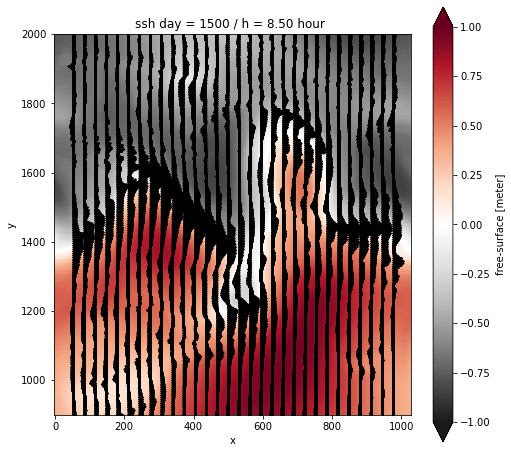

In [27]:
da = r['surf']['ssh']
df.name = 'floats'
kw0 = {'vmin': -1., 'vmax': 1., 'cmap': 'RdGy_r', 
       'extend':'both'}
#kw1 = {'ls': 'dotted', 'color': 'k', 'markersize':1}
kw1 = {'s': 1, 'color': 'k'}
ax_kw = {'ylim': (900, 2000)}
cplt.movie_figure(atom, da, df, i=50, test=True, figsize=(8,8), 
                  ax_kwargs=ax_kw, **{'kw0': kw0, 'kw1':kw1})

In [29]:
from dask import delayed

def movie_wrapper(atom_plot, client, *da, Nt=None, Nb=None, **kwargs):
    """ wrap figure generation in delayed objects that can be distributed to
    workers. Send by batches of Nb figures.
    
    Parameters
    ----------
    atom_plot: method
        Atomic plot method used, should look like:
        def atom_plot(ax, *da, test=..., ax_kwargs=..., **plt_kwargs):
            ...    
    *da: xarray.DataArray's
        Contain data to be plotted.
    Nt: int, optional
        Number of figures generated. Default to entire dataset.
    Nb: int, optional
        Number of figures to generate in each batch. Default to number of 
        available threads
    **kwargs: optional
        Keyword arguments passed on to cplt.movie_figure
    """
    if Nt is None:
        Nt = da[0].time.size
    if Nb is None:
        Nb = len(client.nthreads())
    #
    rg = range(0,Nt)
    II = np.array_split(rg,len(rg)/Nb)
    print('%d batches to be done'%len(II))
    #
    delayed_fig = delayed(cplt.movie_figure)
    #
    df = da[1]
    #
    for I in II:
        print(' batch %d-%d'%(I[0],I[-1]))
        T = da[0].time_instant.values
        values = [delayed_fig(atom_plot, 
                              da[0].isel(time=i),
                              df[ (df.time>=t-dt) & (df.time<=t) ]
                              ,
                              i=i, **kwargs) 
                  for i, t in zip(I,T)]
        futures = client.compute(values)
        results = client.gather(futures)

In [31]:
movie_wrapper(atom, client, 
              da.isel(time=slice(0,None, 6*24)),
              df,
              figsize=(8,8),
              ax_kwargs=ax_kw, **{'kw0': kw0, 'kw1':kw1})

1 batches to be done
 batch 0-99


---

In [10]:
cluster.close()